In [1]:
import numpy as np
from numpy.linalg import norm

In [2]:
from tilelowrankmdd.solver.ipalm import ipalm
from tilelowrankmdd.utils.prox import prox_Fro
from tilelowrankmdd.mdd.mdd_fact import x2lr_global, x2qqt_global

In [3]:
import matplotlib.pyplot as plt

In [4]:
dat = np.load('../../data/pup_pdown_seamsubsalt.npz', allow_pickle=True)

pup_f   = dat['pup']

pdown_f = dat['pdown']

nt = 2025

In [5]:
ret_q, ret_lr = [], []
tol = 1e-7
ifstart, ifend = 10, 600
ns, nr = pdown_f[0].shape
nk = nr//4 

lam = 0.1
proxlist=[prox_Fro(lam)]

for idx in range(ifstart, ifend):

    ia = pdown_f[idx]
    ib = pup_f[idx]
    x0 = np.eye(nr, nk) +  np.eye(nr, nk)*1j
    x0 = [x0.ravel()]
    tau_guess = [norm(ia, 'fro')**2]
    
    iH = x2qqt_global(ia, nk)
    x1 = ipalm(iH, ib, proxlist, x0, tau_guess, tol)
    ret_q.append(x1[0])
    
    iH = x2lr_global(ia, nk)
    x1 = ipalm(iH, ib, proxlist*2, x0*2, tau_guess*2, tol)
    ret_lr.append(x1)

In [6]:
ret_q2 = np.array(ret_q).reshape(ifend-ifstart, nr, nk)
ret_q2 = [iq.dot(iq.T) for iq in ret_q2]
g0 = np.zeros((ifend, nr, nr))*1j
g0[ifstart:] = ret_q2
g0 = np.fft.irfft(g0, n=nt, axis=0)

ret_lr2 = [ilr[0].reshape(nr,nk).dot(ilr[-1].reshape(nk,nr)) for ilr in ret_lr]
ret_lr2 = np.array(ret_lr2).reshape(ifend-ifstart, nr, nr)
ret_lr2.shape
g1 = np.zeros((ifend, nr, nr))*1j
g1[ifstart:] = ret_lr2
g1 = np.fft.irfft(g1, n=nt, axis=0)

Text(0.5, 1.0, 'Common receiver with n/k=4')

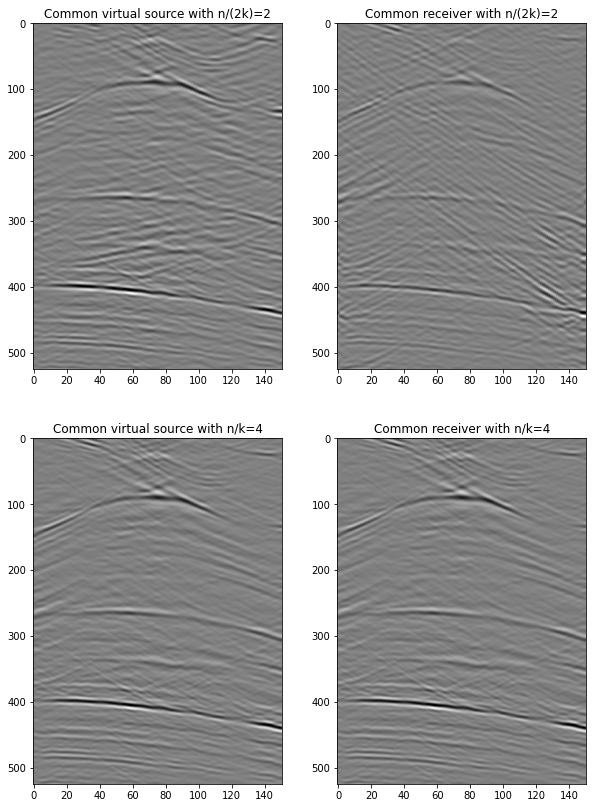

In [7]:
fig, axs = plt.subplots(2,2, figsize=(10,14))
pclip = 0.8

dat = g1[:525, 75] ## the case of factorizing x into l.dot(r) 
cc = np.abs(dat).max()
axs[0][0].imshow(dat, aspect=0.4, vmin=-cc*pclip, vmax=cc*pclip, cmap="gray")
title = 'Common virtual source with n/(2k)=%d'%(nr//nk//2)
axs[0][0].set_title(title)


dat = g1[:525, :, 75] ## the case of factorizing x into l.dot(r) 
cc = np.abs(dat).max()
axs[0][1].imshow(dat, aspect=0.4, vmin=-cc*pclip, vmax=cc*pclip, cmap="gray")
title = 'Common receiver with n/(2k)=%d'%(nr//nk//2)
axs[0][1].set_title(title)

dat = g0[:525, 75] ## the case of factorizing x into l.dot(r) 
cc = np.abs(dat).max()
axs[1][0].imshow(dat, aspect=0.4, vmin=-cc*pclip, vmax=cc*pclip, cmap="gray")
title = 'Common virtual source with n/k=%d'%(nr//nk)
axs[1][0].set_title(title)

dat = g0[:525, :, 75] ## the case of factorizing x into l.dot(r) 
cc = np.abs(dat).max()
axs[1][1].imshow(dat, aspect=0.4, vmin=-cc*pclip, vmax=cc*pclip, cmap="gray")
title = 'Common receiver with n/k=%d'%(nr//nk)
axs[1][1].set_title(title)